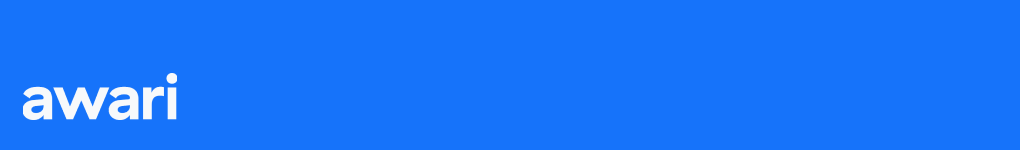

Prática da **Aula 8: Spark e Fontes de Dados**, do curso de **Engenharia de Dados** da **[Awari](https://awari.com.br/)**. 

---

In [ ]:
!pip install boto3
!pip install pyspark

In [1]:
import os
import sys
from datetime import date, datetime
import pyspark
import boto3

from io import StringIO 
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import StructType,StructField, StringType, IntegerType 
from pyspark.sql.types import ArrayType, DoubleType, BooleanType
from pyspark.sql.functions import col,array_contains

# Criando um contexto

In [4]:
# Import SparkSession
from pyspark.sql import SparkSession

# Criando uma sessão com o Spark que existe localmente(atualmente configurado junto com o JupyterLab)
spark = SparkSession.builder \
      .master("local[*]") \
      .appName("AwariAula08") \
      .config("spark.memory.offHeap.enabled","true") \
      .config("spark.memory.offHeap.size","10g") \
      .getOrCreate() 

spark

# Criando um RDD
- Resilient Distributed Datasets, abstraem um conjunto de objetos distribuídos no cluster, geralmente executados na memória principal e podem depois serem salvos em um Haddop, Banco de Datos, arquivo, etc, quando você carrega 
- Um RDD ele é um dado IMUTAVEL e e semelhante a uma lista em Python, com a diferença de que o RDD é calculado em vários processos espalhados por vários servidores físicos, também chamados de nós em um cluster, enquanto uma coleção Python vive e processa em apenas um processo.
- RDD é mais utilizado quando precisamos trabalhar mais baixo nivel manipulando diretamente o DataSet

In [5]:
# Partir da memoria
dataList = [("Java", 20000), ("Python", 100000), ("Scala", 3000)]
rdd=spark.sparkContext.parallelize(dataList)

Py4JJavaError: An error occurred while calling o39.defaultParallelism.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:75)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:53)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:500)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:484)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:1623)

The currently active SparkContext was created at:

(No active SparkContext.)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:120)
	at org.apache.spark.SparkContext.defaultParallelism(SparkContext.scala:2559)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:578)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1623)


In [ ]:
rdd.take(1)

In [ ]:
# A Partir de um arquivo
rdd2 = spark.sparkContext.textFile("./arquivos/customers.csv")
header = rdd2.first()
rdd2 = rdd2.filter(lambda row: row != header)
rdd2.take(5)

# RDD Operações
Transformações no Spark etorna outro RDD e essas transformações são lentas, o que significa que elas não são executadas até que você chame uma ação no RDD. Algumas transformações em RDD's são flatMap(), map(), reduceByKey(), filter(), sortByKey() e retornam um novo RDD ao invés de atualizar o atual.

# RDD Ações
Retorna os valores de um RDD para um nó de driver. Em outras palavras, qualquer função RDD que retorna um não RDD é considerada uma ação. Algumas ações no RDD são count(), collect(), first(), max(), reduce() and more.

# PySpark DataFrame
DataFrame é uma coleção distribuída de dados organizados em colunas nomeadas. É conceitualmente equivalente a uma tabela em um banco de dados relacional ou um quadro de dados em R/Python, mas com otimizações mais ricas sob o capô. Os DataFrames podem ser construídos a partir de uma ampla variedade de fontes, como arquivos de dados estruturados, tabelas no Hive, bancos de dados externos ou RDDs existentes. Diferente do RDD é mais utilizado para analise de dados, debugs, etc.

In [ ]:
# Criando um DataFrame
data = [('James','','Smith','1991-04-01','M',3000),
  ('Michael','Rose','','2000-05-19','M',4000),
  ('Robert','','Williams','1978-09-05','M',4000),
  ('Maria','Anne','Jones','1967-12-01','F',4000),
  ('Jen','Mary','Brown','1980-02-17','F',-1)
]

columns = ["firstname","middlename","lastname","dob","gender","salary"]
df = spark.createDataFrame(data=data, schema = columns)
print(df.show(), df.printSchema())

In [ ]:
# Lendo um arquivo
df = spark.read.option("header", True).csv("./arquivos/customers.csv")
print(df.show(), df.printSchema())

# Arquivos suportados por um PySpark DataFrame

- csv
- text
- Avro
- Parquet
- tsv
- xml e muito mais

# Usando SQL

In [ ]:
df.createOrReplaceTempView("CUSTOMERS")
df2 = spark.sql("SELECT * from CUSTOMERS LIMIT 5")
print(df2.show(), df2.printSchema())

In [ ]:
# Usando GROUPBY
groupDF = spark.sql("SELECT Profession, count(*) as total from CUSTOMERS group by Profession")
groupDF.show()

In [ ]:
spark.stop()

conf = pyspark.SparkConf()

# Criando uma sessão com o Spark que existe localmente(atualmente configurado junto com o JupyterLab)
conf.setMaster("local[1]") 
conf.set("spark.driver.host", "awari-jupyterlab") \
    .set("spark.sql.sources.commitProtocolClass", "org.apache.spark.sql.execution.datasources.SQLHadoopMapReduceCommitProtocol") \
    .set("parquet.enable.summary-metadata", "false") \
    .set("mapreduce.fileoutputcommitter.marksuccessfuljobs", "false") \
    .set("spark.driver.port", "20020") \
    .set("spark.hadoop.fs.s3a.endpoint", 'awari-nginx:9000') \
    .set("spark.hadoop.fs.s3a.endpoint.region", 'sa-east-1') \
    .set("spark.hadoop.fs.s3a.access.key", 'mnYOiUf07UBjjJwf') \
    .set("spark.hadoop.fs.s3a.secret.key", '1Qu7X3EmbIYDNXUiuvFSDUJwJ4fWdyT5') \
    .set("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .set("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
    .set("spark.hadoop.com.amazonaws.services.s3.enableV2", "true") \
    .set("spark.hadoop.fs.s3a.committer.staging.conflict-mode", "replace") \
    .set("spark.hadoop.fs.s3a.fast.upload", True) \
    .set("spark.hadoop.fs.s3a.path.style.access", True) \
    .set("spark.hadoop.fs.s3a.committer.name", "directory") \
    .set("spark.hadoop.fs.s3a.committer.staging.tmp.path", "/tmp/staging")

conf.setAppName('AwariAula08-S33')
sc = pyspark.SparkContext(conf=conf)

spark = SparkSession(sc)

In [ ]:
client = boto3.client('s3', 
    endpoint_url='http://awari-minio-nginx:9000',
    aws_access_key_id='mnYOiUf07UBjjJwf',
    aws_secret_access_key='1Qu7X3EmbIYDNXUiuvFSDUJwJ4fWdyT5',
    aws_session_token=None,
    config=boto3.session.Config(signature_version='s3v4'),
    verify=False,
    region_name='sa-east-1'
)
client

In [ ]:
df = spark.read.option("header", True).csv("s3a://aula-08/resources/usuarios.csv")
print(df.show(), df.printSchema())

In [ ]:
# Usando RDD
# A Partir de um arquivo
rdd3 = spark.sparkContext.textFile("s3a://aula-08/resources/usuarios.csv")
rdd3 = rdd3.map( lambda f: f.split(","))
header = rdd3.first()

rdd3 = rdd3.filter(lambda row: row != header)
rdd3 = sc.parallelize(rdd3.collect())
df = rdd3.toDF(header)
df.show()

In [ ]:
# Convertendo CSV para PARQUET e salvando no storage
df.write.save("s3a://aula-08/meu-parquet")

In [ ]:
# Lendo um parquet file
parDF1=spark.read.parquet("s3a://aula-08/meu-parquet")
parDF1.first()

# DataFrame
Diferente de Series, **DataFrame** possui uma estrutura bidemensial, como uma planilha de Excel.

In [ ]:
data = {
    'macas': [3, 2, 0, 1], 
    'laranjas': [0, 3, 7, 2]
}

compras = pd.DataFrame(data)

compras


In [ ]:
compras = pd.DataFrame(data, index=['Alex', 'Roberto', 'Bernardo', 'Paulo'])

compras

In [ ]:
# para extrair apenas uma Serie
compras.loc['Alex']

# Lendo informações de um CSV

In [ ]:
df = pd.read_csv('arquivos/customers.csv')

df

In [ ]:
# Apenas os 5 primeiros registros
df.head(5)

In [ ]:
# Quando carregamos um CSV os indices são gerados aleatoriamente por ordem da linha 
# caso queiramos especificar um indice, precisaremos informar qual a coluna é o indice

df = pd.read_csv('arquivos/customers.csv', index_col=0)
df.head(5)

# Lendo arquivos em JSON

In [ ]:
df = pd.read_json('./arquivos/estados.json', orient='records')

df

In [ ]:
# Lendo dados de uma URL
url = "https://api.exchangerate-api.com/v4/latest/USD"
df = pd.read_json(url)
print(df)

# Salvando DataFrame em JSON ou CSV

Podemos, usando a mesma lógica, carregar um arquivo JSON salvar em CSV e vice versa

In [ ]:
# Simples formato
df = pd.DataFrame([1,2,3])
print(df)
df.to_json("./arquivos/numeros_json.json")
df.to_csv("./arquivos/numeros_csv.json")
!ls ./arquivos

In [ ]:
df = pd.DataFrame([1,2,3], columns=['Numeros'])
df.to_json("./arquivos/numeros_json2.json")
df.to_csv("./arquivos/numeros_csv2.csv")
!ls ./arquivos

# Tratando um arquivo

In [ ]:
df = pd.read_csv('./arquivos/4300Answers.csv')
df.head(2) # Checar colunas com NaN 

In [ ]:
# Convertendo colunas NaN para "-"
df = df.fillna("-") # Nós precisamos atrelar o resultado a variavel principal
df.head(2) # Checar colunas novamente

In [ ]:
# Retornando apenas o sexo Feminino
resultado_query=df.query("`Qual seu sexo?` == 'Feminino'")
resultado_query.head(2)

In [ ]:
# Salvando novo Json apenas com os resultados femininos
resultado_query.to_csv("./arquivos/4300Answers_femininos.csv")

In [ ]:
# Lendo arquivo gerado
df = pd.read_csv("./arquivos/4300Answers_femininos.csv")
df.head(5)

---

Notebook utilizado para fins educacionais da **Awari**.

**© AWARI. Todos os direitos reservados.**